# Roads - review
do through the roads dataset and integrate it with the accidents data.

In [1]:
# import the required libraries
import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (15, 15) # reset the base size of figure

import seaborn as sns

import folium

In [2]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels
roads = db.roads

In [3]:
# Load the expanded names of keys and human-readable codes into memory
expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

In [4]:
def results_to_table(results, index_name, column_name, results_name, 
                     fillna=None,
                     relabel_index=False, relabel_columns=False,
                     index_label=None, column_label=None):
    
    # Move items in dicts-of-dicts to the top level.
    def flatten(d):
        new_d = {}
        for k in d:
            if isinstance(d[k], dict):
                new_d.update(flatten(d[k]))
            else:
                new_d[k] = d[k]
        return new_d

    df = pd.DataFrame([flatten(r) for r in results])
    df = df.pivot(index=index_name, columns=column_name, values=results_name)
    
    # Optionally, fiddle with names and labels to make the DataFrame pretty.
    if not fillna is None:
        df.fillna(fillna, inplace=True)
    if relabel_columns:
        df.columns = [label_of[column_name, c] for c in df.columns]
    if relabel_index:
        df.index = [label_of[index_name, r] for r in df.index]
    if column_label:
        df.columns.name = column_label
    else:
        df.columns.name = column_name
    if index_label:
        df.index.name = index_label
    else:
        df.index.name = index_name
    return df

## Looking at roads
What is in a 'road' document?

In [5]:
roads.find_one()

{'A-Junction': 'LA Boundary',
 'AADFYear': 2012,
 'B-Junction': 'A4086',
 'CP': 506,
 'Fd2WMV': 29.0,
 'FdAll_MV': 2108.0,
 'FdBUS': 17.0,
 'FdCar': 1599.0,
 'FdHGV': 66.0,
 'FdHGVA3': 3.0,
 'FdHGVA5': 10.0,
 'FdHGVA6': 7.0,
 'FdHGVR2': 40.0,
 'FdHGVR3': 2.0,
 'FdHGVR4': 4.0,
 'FdLGV': 397.0,
 'FdPC': 20.0,
 'Latitude': 53.12266010696906,
 'LenNet': 8.4,
 'LenNet_miles': 5.21,
 'Longitude': -4.001657045120545,
 'ONS GOR Name': 'Wales',
 'ONS LA Name': 'Conwy',
 'RCat': 'TR',
 'Road': 'A5',
 'S Ref E': 266150,
 'S Ref N': 360260,
 '_id': ObjectId('533ed2c589f6f9ee18bae9e5'),
 'loc': {'coordinates': [-4.001657045120545, 53.12266010696906],
  'type': 'Point'},
 'nearby_accident_count': 1,
 'nearby_accidents': ['201260N115372']}

It's a section of road with totals of different vehicle types that passed along that section. Road sections have two ends, either junctions or region boundaries. The `Fd...` keys are the number of vehicles of a particular class that passed this point (in the forward direction, but there's no 'reverse' direction specified).

What do the codes mean?

In [6]:
expanded_name['FdAll_MV']

'All motor vehicles'

In [7]:
expanded_name['FdHGVA6']

'Articulated HGV with six axles'

What are the road categories?


In [8]:
[(c, label_of['RCat', c]) for k, c in label_of if k == 'RCat']

[('BR', 'Rural B road'),
 ('CU', 'Urban C road'),
 ('TR', 'Rural trunk road'),
 ('CR', 'Rural C road'),
 ('PU', 'Urban principal road'),
 ('UU', 'Urban U road'),
 ('TU', 'Urban trunk road'),
 ('PR', 'Rural principal road'),
 ('BU', 'Urban B road'),
 ('TM', 'Trunk motorway'),
 ('PM', 'Principal motorway'),
 ('UR', 'Rural U road')]

Note that not every road segment has a location. We'll have to bear that in mind when doing geographic analysis of the roads dataset.

In [9]:
roads.find({'loc': {'$exists':False}}).count()

96

In [10]:
roads.find({'loc': {'$exists': True}}).count()

17891

## Plotting some road points
To start with, we'll plot some road segments on the map to see where they are.  We'll reuse the map-making procedures from Notebook 15.1

In [11]:
def add_accidents_markers(the_map, query, number_of_sides=5, fill_color='#769d96', limit=0,
                     radius=5, rotation=54):
    for a in accidents.find(query, 
                            ['loc.coordinates'],
                            limit=limit):
        folium.RegularPolygonMarker(location=[a['loc']['coordinates'][1], a['loc']['coordinates'][0]], 
                     number_of_sides=number_of_sides, radius=radius, rotation=rotation,
                                   fill_color=fill_color).add_to(the_map)  

In [12]:
def add_roads_markers(the_map, query, number_of_sides=5, fill_color='#769d96', limit=0,
                     radius=5, rotation=54):
    for r in roads.find(query, 
                        ['loc.coordinates'],
                       limit=limit):
        folium.RegularPolygonMarker(location=[r['loc']['coordinates'][1], r['loc']['coordinates'][0]], 
                     number_of_sides=number_of_sides, radius=radius, rotation=rotation,
                                   fill_color=fill_color).add_to(the_map)    

In [13]:
m = folium.Map([55, -3], zoom_start=6)

add_roads_markers(m, {'loc': {'$exists': True}}, limit=1000)
m

This clearly shows that the road data covers Britain, but nothing in Ireland.

## Milton Keynes
Let's zoom in a bit on Milton Keynes, the home of the Open University.  This polygon defines the area we're interested in.

In [14]:
milton_keynes = {'type': 'Polygon',
                               'coordinates': [[[-0.869719, 52.066547], 
                                                [-0.651709, 52.066547], 
                                                [-0.651709, 51.997161], 
                                                [-0.869719, 51.997161],
                                                [-0.869719, 52.066547]
                                                ]]}

min_mk_lat = min(p[1] for p in milton_keynes['coordinates'][0])
max_mk_lat = max(p[1] for p in milton_keynes['coordinates'][0])
min_mk_lon = min(p[0] for p in milton_keynes['coordinates'][0])
max_mk_lon = max(p[0] for p in milton_keynes['coordinates'][0])

mk_centre = [min_mk_lat + (max_mk_lat - min_mk_lat) / 2, min_mk_lon + (max_mk_lon - min_mk_lon) / 2]

mk_region_query = {'loc': {'$geoWithin': {'$geometry': milton_keynes}}}

In [15]:
roads.find(mk_region_query).count()

24

In [16]:
[r for r in roads.find(mk_region_query, 
                       {'FdAll_MV':1, 'Road':1, 'RCat':1, 'LenNet':1, '_id':0})]

[{'FdAll_MV': 18805.0, 'LenNet': 4.2, 'RCat': 'PU', 'Road': 'A4146'},
 {'FdAll_MV': 32672.0, 'LenNet': 2.2, 'RCat': 'TU', 'Road': 'A5'},
 {'FdAll_MV': 32141.0, 'LenNet': 1.8, 'RCat': 'TR', 'Road': 'A5'},
 {'FdAll_MV': 17263.0, 'LenNet': 0.7, 'RCat': 'PU', 'Road': 'A421'},
 {'FdAll_MV': 31404.0, 'LenNet': 3.2, 'RCat': 'PU', 'Road': 'A421'},
 {'FdAll_MV': 20217.0, 'LenNet': 3.6, 'RCat': 'PU', 'Road': 'A422'},
 {'FdAll_MV': 42642.0, 'LenNet': 1.9, 'RCat': 'TU', 'Road': 'A5'},
 {'FdAll_MV': 35490.0, 'LenNet': 1.2, 'RCat': 'TR', 'Road': 'A5'},
 {'FdAll_MV': 32366.0, 'LenNet': 4.0, 'RCat': 'TR', 'Road': 'A5'},
 {'FdAll_MV': 29862.0, 'LenNet': 3.0, 'RCat': 'PU', 'Road': 'A422'},
 {'FdAll_MV': 18107.0, 'LenNet': 2.8, 'RCat': 'PU', 'Road': 'A509'},
 {'FdAll_MV': 23224.0, 'LenNet': 2.5, 'RCat': 'PU', 'Road': 'A509'},
 {'FdAll_MV': 37847.0, 'LenNet': 4.3, 'RCat': 'TU', 'Road': 'A5'},
 {'FdAll_MV': 16478.0, 'LenNet': 0.7, 'RCat': 'PR', 'Road': 'A509'},
 {'FdAll_MV': 41262.0, 'LenNet': 0.5, 'RCat':

In [17]:
mk_region_query

{'loc': {'$geoWithin': {'$geometry': {'coordinates': [[[-0.869719, 52.066547],
      [-0.651709, 52.066547],
      [-0.651709, 51.997161],
      [-0.869719, 51.997161],
      [-0.869719, 52.066547]]],
    'type': 'Polygon'}}}}

In [18]:
m = folium.Map(mk_centre, zoom_start=12)    
add_accidents_markers(m, mk_region_query, fill_color='#ff0000', number_of_sides=6, radius=4)
add_roads_markers(m, mk_region_query, fill_color='#0000ff', number_of_sides=4, radius=10)
m

This clearly shows that not all roads have traffic flow data.

# Exploring the roads data
Let's have a look at some of the numbers associated with the traffic flow data.  We'll load the data into a DataFrame and make some graphs.

How many of each type of road section are there, and how long are they?

In [19]:
pipeline = [{'$group': {'_id': '$RCat', 
                        'length': {'$avg': '$LenNet'},
                        'count': {'$sum': 1}}}]

results = list(roads.aggregate(pipeline))
results

[{'_id': 'PM', 'count': 38, 'length': 1.0894736842105264},
 {'_id': 'TM', 'count': 1111, 'length': 3.2201800180018},
 {'_id': 'TR', 'count': 1812, 'length': 4.467235099337748},
 {'_id': 'PR', 'count': 6106, 'length': 4.515180150671471},
 {'_id': 'PU', 'count': 8614, 'length': 1.238450197353146},
 {'_id': 'TU', 'count': 306, 'length': 1.3468627450980393}]

In [20]:
# put these results into a data frame and look up the category labels
road_lens_df = pd.DataFrame(results)
road_lens_df.set_index('_id', inplace=True)
road_lens_df.index.name = 'RCat'
# look up each category name
road_lens_df['category'] = [label_of['RCat', c] for c in road_lens_df.index]
road_lens_df

,count,length,category
RCat,,,
PM,38,1.089474,Principal motorway
TM,1111,3.220180,Trunk motorway
TR,1812,4.467235,Rural trunk road
PR,6106,4.515180,Rural principal road
PU,8614,1.238450,Urban principal road
TU,306,1.346863,Urban trunk road


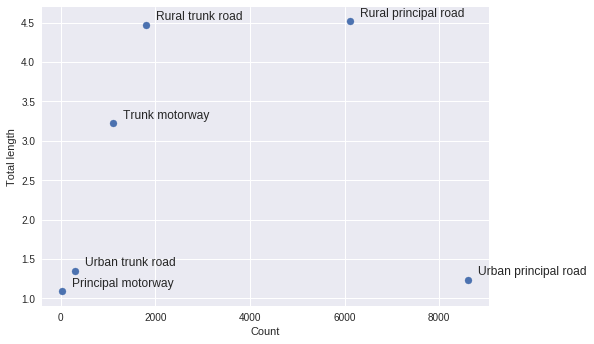

In [21]:
# plot as a scattes
plt.scatter(road_lens_df['count'],
            road_lens_df['length'])
plt.xlabel('Count')
plt.ylabel('Total length')

# add labels to each point
for r in road_lens_df.iterrows():
    plt.annotate(r[1]['category'], xy=(r[1]['count'], r[1]['length']),
                 xytext=(10, 5), textcoords='offset points')

plt.show()

let's redo that plot as it isn't very pretty

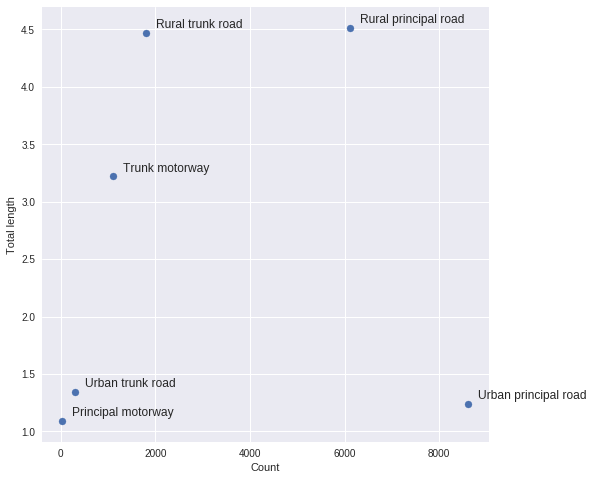

In [22]:
# make the figure size mora appropriate
mpl.rcParams['figure.figsize'] = (8, 8)

# plot as a scattes
plt.scatter(road_lens_df['count'],
            road_lens_df['length'])
plt.xlabel('Count')
plt.ylabel('Total length')

# add labels to each point
for r in road_lens_df.iterrows():
    plt.annotate(r[1]['category'], xy=(r[1]['count'], r[1]['length']),
                 xytext=(10, 5), textcoords='offset points')

plt.show()

Unsurprisingly, rural road sections are longer than urban road sections.  There are more 'principle' than 'trunk' road sections, probably because 'trunk' roads are designated major routes.

But what are principle motorways?

In [23]:
roads.distinct('Road', {'RCat': 'PM'})

['A57M',
 'M65',
 'A64M',
 'M62',
 'A329M',
 'A167M',
 'A601M',
 'M56',
 'M275',
 'A38M',
 'A58M',
 'M55']

The average lengths shown so far don't tell us about the distribution of lengths of different roads.

In [24]:
road_lengths_df = pd.DataFrame(list(roads.find({}, ['RCat', 'LenNet'])))
road_lengths_df.describe()

,LenNet
count,17987.000000
mean,2.799994
std,3.816937
min,0.070000
25%,0.600000
50%,1.500000
75%,3.300000
max,55.500000


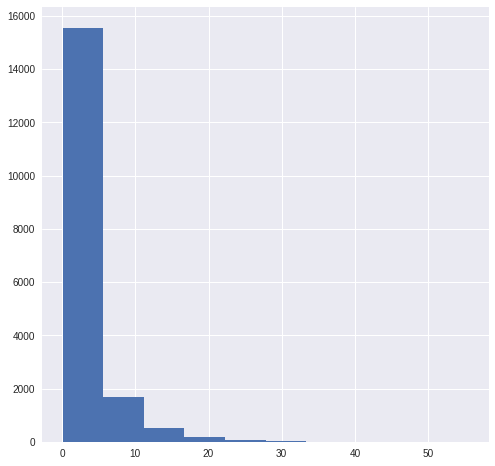

In [25]:
road_lengths_df['LenNet'].hist()

Most road sections are very short, with a few that are longer.

Is there a difference between rural and urban sections?

In [26]:
# categorize the data 
isUrban = road_lengths_df.apply(lambda r: r['RCat'][1] == 'U', axis=1)
isRural = road_lengths_df.apply(lambda r: r['RCat'][1] == 'R', axis=1)

In [27]:
road_lengths_df[isUrban]['LenNet'].describe()

count    8920.000000
mean        1.242169
std         1.078233
min         0.070000
25%         0.400000
50%         0.900000
75%         1.700000
max        10.600000
Name: LenNet, dtype: float64

In [28]:
road_lengths_df[isRural]['LenNet'].describe()

count    7918.000000
mean        4.504208
std         4.949380
min         0.100000
25%         1.100000
50%         2.800000
75%         6.175000
max        55.500000
Name: LenNet, dtype: float64

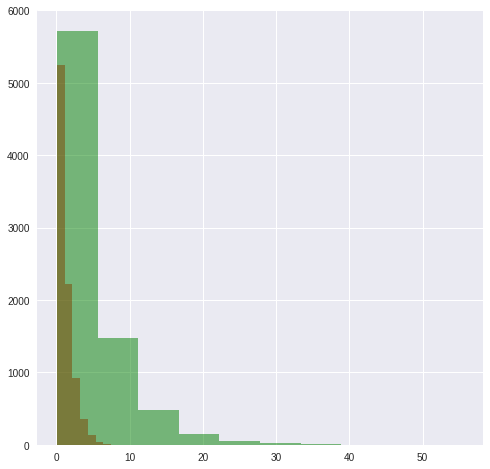

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
road_lengths_df[isUrban]['LenNet'].hist(ax=ax, alpha=0.5, color='red')
road_lengths_df[isRural]['LenNet'].hist(ax=ax, alpha=0.5, color='green')

This shows that, while both urban and rural roads have a similar rhape of road length distributions (many short sections with some longer sections), the rural roads are much longer than the urban ones

## Looking at districts
Which districts have the most roads, and the longest roads?

We'll use a pipeline to find the data and plot it on a scatter plot

In [30]:
pipeline = [{'$group': {'_id': '$ONS LA Name',
                        'length': {'$sum': '$LenNet'},
                        'count': {'$sum': 1}}}]
results = list(roads.aggregate(pipeline))
results

[{'_id': 'Isles of Scilly', 'count': 5, 'length': 7.7},
 {'_id': 'Plymouth', 'count': 33, 'length': 42.0},
 {'_id': 'Havering', 'count': 33, 'length': 61.3},
 {'_id': 'Isle of Anglesey', 'count': 42, 'length': 174.1},
 {'_id': 'Newcastle upon Tyne', 'count': 78, 'length': 89.9},
 {'_id': 'Wakefield', 'count': 93, 'length': 203.96},
 {'_id': 'Calderdale', 'count': 65, 'length': 148.0},
 {'_id': 'York', 'count': 54, 'length': 96.32},
 {'_id': 'Conwy', 'count': 61, 'length': 232.9},
 {'_id': 'Trafford', 'count': 43, 'length': 67.9},
 {'_id': 'Lincolnshire', 'count': 201, 'length': 1108.11},
 {'_id': 'Halton', 'count': 43, 'length': 56.05},
 {'_id': 'Liverpool', 'count': 165, 'length': 124.4},
 {'_id': 'Barnsley', 'count': 76, 'length': 167.9},
 {'_id': 'Islington', 'count': 64, 'length': 38.1},
 {'_id': 'Bradford', 'count': 109, 'length': 154.7},
 {'_id': 'Kent', 'count': 466, 'length': 1134.94},
 {'_id': 'Warwickshire', 'count': 225, 'length': 619.0},
 {'_id': 'Cumbria', 'count': 206, 'l

In [31]:
def results_to_scatter_table(results, index_name):
    df = pd.DataFrame(results)
    df.set_index('_id', inplace=True)
    df.index.name = index_name
    return df


In [32]:
ons_lens_df = results_to_scatter_table(results, 'LA')
ons_lens_df.head()

,count,length
LA,,
Isles of Scilly,5,7.7
Plymouth,33,42.0
Havering,33,61.3
Isle of Anglesey,42,174.1
Newcastle upon Tyne,78,89.9


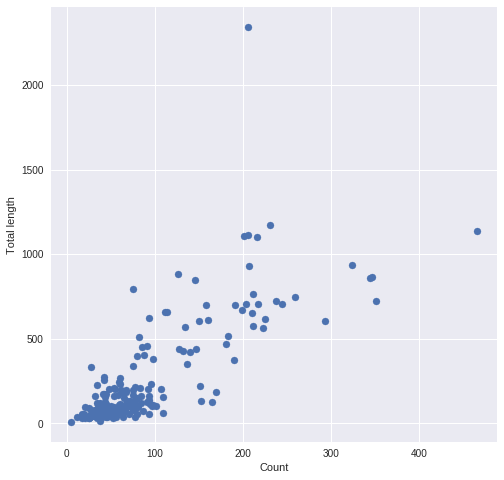

In [33]:
plt.scatter(ons_lens_df['count'],
            ons_lens_df['length'])
plt.xlabel('Count')
plt.ylabel('Total length')
plt.show()

What are those two outliers (longest roads and most roads)?

In [34]:
# Which district has the most road sections?
ons_lens_df.loc[ons_lens_df['count'].idxmax()]

count      466.00
length    1134.94
Name: Kent, dtype: float64

In [35]:
# Which district has the longest total of road sections?
ons_lens_df.loc[ons_lens_df['length'].idxmax()]

count      206.0
length    2344.8
Name: Highland, dtype: float64

### Activity 1
Which districts have the most, and longest, road networks, when split between rural and urban?

Generate data that shows the number of road segments, and total length of road segments, grouped by both district and whether the road is rural or urban. Create scatter plots to show districts by rural road count vs urban road count, and rural road length vs urban road length. 

Comment on your findings.

**Hint**: You can tell is a road is rural or urban from the second character of the road category code, `R` or `U`. If you're using an aggregation pipeline to find the data, use `'class': {'$substr': ['$RCat', 1, 1]}` inside a `$project` stage to pick out the appropriate character.

The solution is in the [`15.3solutions`](15.3solutions.ipynb) Notebook.

In [43]:
pipeline = [
    {'$project': {'ONS LA Name': '$ONS LA Name',
                  'class': {'$substr': ['$RCat', 1, 1]},
                  'LenNet': '$LenNet'}},
    {'$match': {'class': {'$in': ['R', 'U']}}},
    {'$group': {'_id': {'ONS_LA_Name': '$ONS LA Name',
                        'class': '$class'},
                'length': {'$sum': '$LenNet'},
                'count': {'$sum': 1}}}]

results = list(roads.aggregate(pipeline))
results

[{'_id': {'ONS_LA_Name': 'Croydon', 'class': 'R'}, 'count': 1, 'length': 0.4},
 {'_id': {'ONS_LA_Name': 'Barking and Dagenham', 'class': 'R'},
  'count': 1,
  'length': 0.4},
 {'_id': {'ONS_LA_Name': 'Harrow', 'class': 'R'}, 'count': 1, 'length': 0.6},
 {'_id': {'ONS_LA_Name': 'Dundee City', 'class': 'R'},
  'count': 3,
  'length': 2.7},
 {'_id': {'ONS_LA_Name': 'Reading', 'class': 'R'}, 'count': 1, 'length': 0.3},
 {'_id': {'ONS_LA_Name': 'Plymouth', 'class': 'R'}, 'count': 2, 'length': 4.2},
 {'_id': {'ONS_LA_Name': 'Manchester', 'class': 'R'},
  'count': 1,
  'length': 2.0},
 {'_id': {'ONS_LA_Name': 'Poole', 'class': 'R'}, 'count': 5, 'length': 7.0},
 {'_id': {'ONS_LA_Name': 'Moray', 'class': 'U'}, 'count': 6, 'length': 7.5},
 {'_id': {'ONS_LA_Name': 'Birmingham', 'class': 'R'},
  'count': 4,
  'length': 6.1},
 {'_id': {'ONS_LA_Name': 'Havering', 'class': 'R'}, 'count': 4, 'length': 8.5},
 {'_id': {'ONS_LA_Name': 'Aberdeenshire', 'class': 'U'},
  'count': 8,
  'length': 12.0},
 {'_i

In [37]:
ons_class_df = results_to_table(results, 'ONS_LA_Name', 'class', 'count',
                                fillna=0)
ons_class_df.head()

class,R,U
ONS_LA_Name,,
Aberdeen City,14.0,44.0
Aberdeenshire,119.0,8.0
Angus,40.0,19.0
Argyll & Bute,73.0,3.0
Barking and Dagenham,1.0,26.0


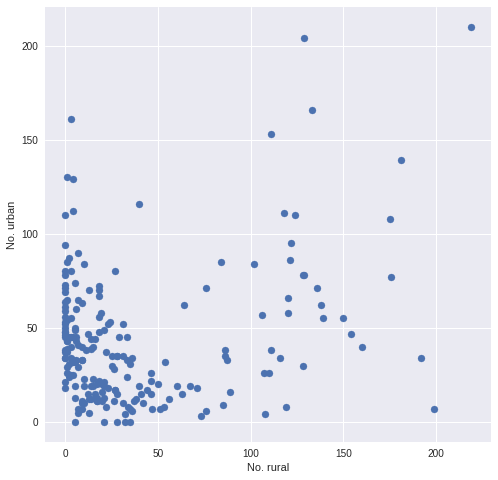

In [38]:
plt.scatter(ons_class_df['R'],
            ons_class_df['U'])
plt.xlabel('No. rural')
plt.ylabel('No. urban')
plt.show()

In [39]:
# Which is the district in the top-right corner?
ons_class_df.loc[ons_class_df['R'].idxmax()]

class
R    219.0
U    210.0
Name: Kent, dtype: float64

Kent has the most rural and urban roads

In [40]:
ons_class_df.sort_values('U', ascending=False).head()

class,R,U
ONS_LA_Name,,
Kent,219.0,210.0
Surrey,129.0,204.0
Lancashire,133.0,166.0
Liverpool,3.0,161.0
Hertfordshire,111.0,153.0


In [41]:
ons_class_df.sort_values('R', ascending=False).head()

class,R,U
ONS_LA_Name,,
Kent,219.0,210.0
Highland,199.0,7.0
Devon,192.0,34.0
Staffordshire,181.0,139.0
Derbyshire,176.0,77.0


In [42]:
ons_class_df[(ons_class_df['R'] > 150) | (ons_class_df['U'] > 150)]

class,R,U
ONS_LA_Name,,
Derbyshire,176.0,77.0
Devon,192.0,34.0
Hampshire,175.0,108.0
Hertfordshire,111.0,153.0
Highland,199.0,7.0
Kent,219.0,210.0
Lancashire,133.0,166.0
Lincolnshire,154.0,47.0
Liverpool,3.0,161.0


Now to look at the road lengths.

In [46]:
results[:5]

[{'_id': {'ONS_LA_Name': 'Croydon', 'class': 'R'}, 'count': 1, 'length': 0.4},
 {'_id': {'ONS_LA_Name': 'Barking and Dagenham', 'class': 'R'},
  'count': 1,
  'length': 0.4},
 {'_id': {'ONS_LA_Name': 'Harrow', 'class': 'R'}, 'count': 1, 'length': 0.6},
 {'_id': {'ONS_LA_Name': 'Dundee City', 'class': 'R'},
  'count': 3,
  'length': 2.7},
 {'_id': {'ONS_LA_Name': 'Reading', 'class': 'R'}, 'count': 1, 'length': 0.3}]

In [47]:
# build the new dataframe
ons_class_len_df = results_to_table(results, 'ONS_LA_Name', 'class', 'length', fillna=0)
ons_class_len_df.head()

class,R,U
ONS_LA_Name,,
Aberdeen City,28.2,59.6
Aberdeenshire,872.3,12.0
Angus,216.0,26.0
Argyll & Bute,788.9,8.0
Barking and Dagenham,0.4,36.7


<function matplotlib.pyplot.show>

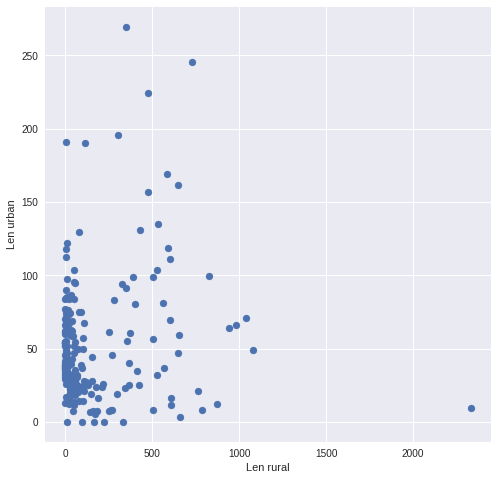

In [48]:
# plot the urban vs rural scatter
plt.scatter(ons_class_len_df['R'],
            ons_class_len_df['U'])
plt.xlabel('Len rural')
plt.ylabel('Len urban')
plt.show

Again we can look at the most urban and rural.

In [50]:
ons_class_len_df.sort_values('U', ascending=False).head()

class,R,U
ONS_LA_Name,,
Surrey,349.72,269.57
Kent,727.64,245.60
Lancashire,476.50,224.30
Hertfordshire,300.40,195.90
Birmingham,6.10,191.10


In [51]:
ons_class_len_df.sort_values('R', ascending=False).head()

class,R,U
ONS_LA_Name,,
Highland,2335.20,9.6
Devon,1082.37,49.4
Lincolnshire,1037.41,70.7
North Yorkshire,982.50,66.2
Cumbria,942.90,64.4


There are a lot of districts on the left hand edge of the scatter plot. Can we pick them out?  How about by finding the ratio of urban to rural lengths and finding the outliers.

In [53]:
# add the ratio column
ons_class_len_df['UvR'] = ons_class_len_df['U'] / ons_class_len_df['R']

# look at those with no urban roads
ons_class_len_df.sort_values('UvR').head(10)

class,R,U,UvR
ONS_LA_Name,,,
Shetland Islands,225.0,0.00,0.000000
Rutland,95.5,0.00,0.000000
Orkney Islands,163.8,0.00,0.000000
Isles of Scilly,7.7,0.00,0.000000
Comhairle nan Eilean Siar,333.3,0.00,0.000000
Highland,2335.2,9.60,0.004111
Powys,657.2,3.30,0.005021
Argyll & Bute,788.9,8.00,0.010141
Aberdeenshire,872.3,12.00,0.013757


In [55]:
# look at those with no rural
ons_class_len_df.sort_values('UvR', ascending=False).head(10)

class,R,U,UvR
ONS_LA_Name,,,
Brent,0.0,52.80,inf
"Kingston upon Hull, City of",0.0,45.75,inf
City of London,0.0,12.85,inf
Richmond upon Thames,0.0,61.90,inf
Southend-on-Sea,0.0,33.50,inf
Camden,0.0,38.00,inf
Southwark,0.0,54.00,inf
Newham,0.0,52.10,inf
Ealing,0.0,54.20,inf


How many districts are urban only?

In [56]:
ons_class_len_df[ons_class_len_df['R']==0].count(), ons_class_len_df.count()

(class
 R      24
 U      24
 UvR    24
 dtype: int64, class
 R      206
 U      206
 UvR    206
 dtype: int64)

24 districts of the 206 as a percentage is

In [59]:
print('{0}% are urban only'.format(24/206))

0.11650485436893204% are urban only


Almost 12% are rural only.

In [61]:
ons_class_len_df[ons_class_len_df['U']==0].count(), ons_class_len_df.count()

(class
 R      5
 U      5
 UvR    5
 dtype: int64, class
 R      206
 U      206
 UvR    206
 dtype: int64)

In [62]:
5/206

0.024271844660194174

While 5 are urban only. 2.4% are urban only.

### Traffic volume distributions
What can we tell about how heavily used different roads are?

In [64]:
traffic_volume_df = pd.DataFrame(list(roads.find({}, ['Road', 'RCat', 'FdAll_MV', 'LenNet'])))
traffic_volume_df.describe()

,FdAll_MV,LenNet
count,17987.000000,17987.000000
mean,20543.581642,2.799994
std,21405.409276,3.816937
min,80.000000,0.070000
25%,8588.500000,0.600000
50%,14606.000000,1.500000
75%,23481.500000,3.300000
max,207485.000000,55.500000


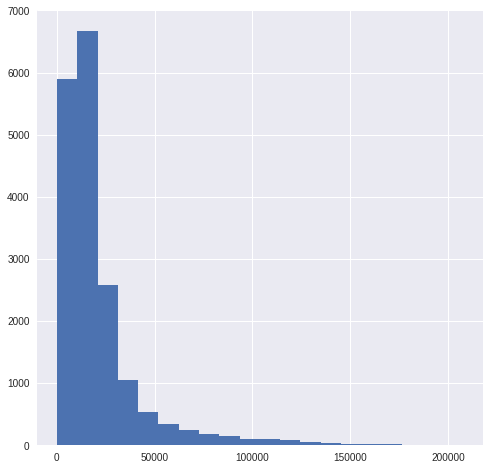

In [68]:
traffic_volume_df['FdAll_MV'].hist(bins=20)

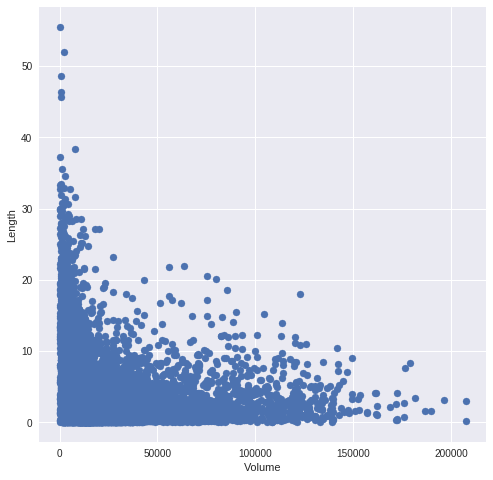

In [69]:
plt.scatter(traffic_volume_df['FdAll_MV'],
            traffic_volume_df['LenNet'])
plt.xlabel('Volume')
plt.ylabel('Length')

In [70]:
# apply the same Urban, Rural classification
isUrban = traffic_volume_df.apply(lambda r: r['RCat'][1]=='U', axis=1)
isRural = traffic_volume_df.apply(lambda r: r['RCat'][1]=='R', axis=1)

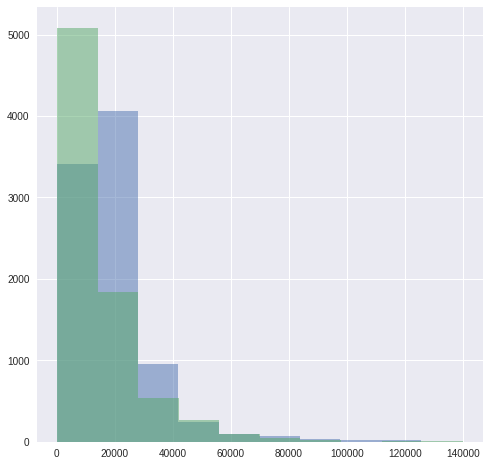

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)

traffic_volume_df[isUrban]['FdAll_MV'].hist(ax=ax, alpha=0.5)
traffic_volume_df[isRural]['FdAll_MV'].hist(ax=ax, alpha=0.5)

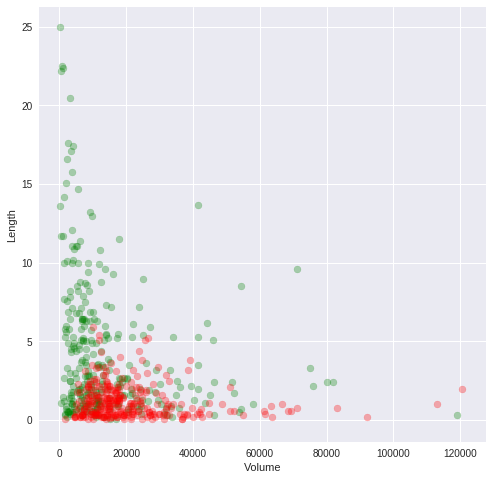

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)

rurals = traffic_volume_df[isRural].sample(300)
urbans = traffic_volume_df[isUrban].sample(300)

ax.scatter(rurals['FdAll_MV'], rurals['LenNet'], 
           color='green', alpha=0.3)
ax.scatter(urbans['FdAll_MV'], urbans['LenNet'], 
           color='red', alpha=0.3)


plt.xlabel('Volume')
plt.ylabel('Length')

plt.show()

This shows the different types of road use between rural and urban: urban roads tend to have higher volumes on shorter segments than rural areas.

In [74]:
# What road segment has the highest traffic?
traffic_volume_df.iloc[traffic_volume_df['FdAll_MV'].idxmax()]['Road']

'M25'

In [75]:
# What are the busiest road sections?
traffic_volume_df.sort_values(by='FdAll_MV', ascending=False).head(10)

,FdAll_MV,LenNet,RCat,Road,_id
12639,207485.0,0.2,TM,M25,533ed2c589f6f9ee18bb1b44
5412,207485.0,3.0,TM,M25,533ed2c589f6f9ee18baff09
9234,196279.0,3.1,TM,M25,533ed2c589f6f9ee18bb0df7
8176,190044.0,1.6,TM,M60,533ed2c589f6f9ee18bb09d5
4239,186726.0,1.6,TM,M1,533ed2c589f6f9ee18bafa74
7329,181764.0,3.5,TM,M25,533ed2c589f6f9ee18bb0686
1477,179080.0,8.4,TM,M25,533ed2c589f6f9ee18baefaa
1476,176572.0,7.7,TM,M25,533ed2c589f6f9ee18baefa9
2345,176274.0,2.7,TM,M60,533ed2c589f6f9ee18baf30e
12239,176274.0,0.8,TM,M60,533ed2c589f6f9ee18bb19b4


## Activity 2

### Activity 2
Do different types of roads have different mixes of traffic? For each road category, find the average daily flow when averaged across all road segments of that category. Place the results in a DataFrame and plot them as a bar chart.

Investigate whether the mix of vehicle types is different on different road types. Use a suitable statistical test to determine if the differences you see are significant (you may want to refer back to Notebook 14.3).

Use just the total HGV counts, not the counts for each type of goods vehicle.

The solution is in the [`15.3solutions`](15.3solutions.ipynb) Notebook.

In [81]:
roads.find_one()

{'A-Junction': 'LA Boundary',
 'AADFYear': 2012,
 'B-Junction': 'A4086',
 'CP': 506,
 'Fd2WMV': 29.0,
 'FdAll_MV': 2108.0,
 'FdBUS': 17.0,
 'FdCar': 1599.0,
 'FdHGV': 66.0,
 'FdHGVA3': 3.0,
 'FdHGVA5': 10.0,
 'FdHGVA6': 7.0,
 'FdHGVR2': 40.0,
 'FdHGVR3': 2.0,
 'FdHGVR4': 4.0,
 'FdLGV': 397.0,
 'FdPC': 20.0,
 'Latitude': 53.12266010696906,
 'LenNet': 8.4,
 'LenNet_miles': 5.21,
 'Longitude': -4.001657045120545,
 'ONS GOR Name': 'Wales',
 'ONS LA Name': 'Conwy',
 'RCat': 'TR',
 'Road': 'A5',
 'S Ref E': 266150,
 'S Ref N': 360260,
 '_id': ObjectId('533ed2c589f6f9ee18bae9e5'),
 'loc': {'coordinates': [-4.001657045120545, 53.12266010696906],
  'type': 'Point'},
 'nearby_accident_count': 1,
 'nearby_accidents': ['201260N115372']}

In [84]:
# very important method
[(c, label_of['RCat', c]) for k, c in label_of if k == 'RCat']

# look at the expanded codes for possible vehicle types
expanded_name['FdPC']

'Pedal cycles'

In [88]:
pipeline = [{'$group': {'_id': '$RCat',
                        'Fd2WMV': {'$avg': '$Fd2WMV'},
                        'FdBUS': {'$avg': '$FdBUS'},
                        'FdCar': {'$avg': '$FdCar'},
                        'FdHGV': {'$avg': '$FdHGV'},
                        'FdLGV': {'$avg': '$FdLGV'},
                        'FdPC': {'$avg': '$FdPC'}}}]
results = list(roads.aggregate(pipeline))

In [91]:
results_df = results_to_scatter_table(results, 'Road_Type')
results_df.index = [label_of['RCat', r] for r in results_df.index]
results_df.columns = [expanded_name[c] for c in results_df.columns]
results_df

,"Motorcycles, etc.",Busses,Cars,All HGVs,Light vans,Pedal cycles
Principal motorway,277.289474,404.763158,43802.552632,1886.868421,6281.447368,0.000000
Trunk motorway,265.202520,294.498650,53301.377138,7094.188119,9244.034203,0.000000
Rural trunk road,150.352649,115.907285,19290.211369,2084.520971,3408.645143,7.759382
Rural principal road,93.382575,81.821815,9232.650508,509.996725,1537.345234,25.746315
Urban principal road,256.967727,374.085558,15437.734966,586.001161,2360.560947,246.192477
Urban trunk road,201.624183,208.732026,27173.107843,1959.470588,4417.084967,48.885621


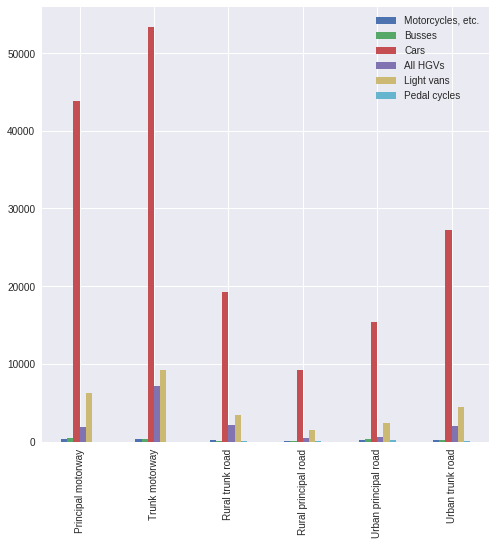

In [92]:
# lets look at a simple bar plot
results_df.plot(kind='bar')

To see if vehicle mixes are different on different roads we need to use a chi-squared test.  First we'll need to ignore the pedal cycles as there are none on the motorway!  Then we can find the expected volumes for each vehicle type, assuming no variation between road types.

In [93]:
reduced_results_df = results_df.drop('Pedal cycles', axis=1)
reduced_results_df

,"Motorcycles, etc.",Busses,Cars,All HGVs,Light vans
Principal motorway,277.289474,404.763158,43802.552632,1886.868421,6281.447368
Trunk motorway,265.202520,294.498650,53301.377138,7094.188119,9244.034203
Rural trunk road,150.352649,115.907285,19290.211369,2084.520971,3408.645143
Rural principal road,93.382575,81.821815,9232.650508,509.996725,1537.345234
Urban principal road,256.967727,374.085558,15437.734966,586.001161,2360.560947
Urban trunk road,201.624183,208.732026,27173.107843,1959.470588,4417.084967


In [95]:
# lets tidy up the order
reduced_results_df.sort_index(axis=0, inplace=True)
reduced_results_df.sort_index(axis=1, inplace=True)
reduced_results_df

,All HGVs,Busses,Cars,Light vans,"Motorcycles, etc."
Principal motorway,1886.868421,404.763158,43802.552632,6281.447368,277.289474
Rural principal road,509.996725,81.821815,9232.650508,1537.345234,93.382575
Rural trunk road,2084.520971,115.907285,19290.211369,3408.645143,150.352649
Trunk motorway,7094.188119,294.498650,53301.377138,9244.034203,265.202520
Urban principal road,586.001161,374.085558,15437.734966,2360.560947,256.967727
Urban trunk road,1959.470588,208.732026,27173.107843,4417.084967,201.624183


In [96]:
# chi square test
chi2, p, _, _ = scipy.stats.chi2_contingency(reduced_results_df)
chi2, p

(3686.1191293657189, 0.0)

with a _p_ value of 0 we can reject the null hypothesis that the vehicle mixes are the same on all road types.  So we can state that different road types really do have different traffic mixes.